In [388]:
# base packages
from os import path
import pickle

# Third party modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import umap
import hdbscan

from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# project code
from project_code.clustering import AutoEncoder

# Autoencoder Deep Embeddings

The following code implements a standard feed-foreward autoencoder (from [N2D](https://n2d.readthedocs.io/en/latest/), but the **N2D framework is not used**).

## Training The Encodings

The autoencoder is used to learn a 2D embedding of the standardized data.

**The training process produces a lot of text**

In [4]:
data = pd.read_csv('../_data/std_df.csv')

In [5]:
ae = AutoEncoder(data.shape[-1], 2)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
ae.fit(
    data,
    batch_size=10000,
    epochs=500,
    loss="mse",
    optimizer="adam",
    weights=None,
    verbose=1,
    weight_id=None,
    patience=None,
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
307511/307511 [==============================] - 14s 45us/sample - loss: 0.2198
Epoch 2/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1776
Epoch 3/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1637
Epoch 4/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1540
Epoch 5/500
307511/307511 [==============================] - 5s 16us/sample - loss: 0.1486
Epoch 6/500
307511/307511 [==============================] - 5s 16us/sample - loss: 0.1414
Epoch 7/500
307511/307511 [==============================] - 5s 16us/sample - loss: 0.1354
Epoch 8/500
307511/307511 [==============================] - 5s 16us/sample - loss: 0.1292
Epoch 9/500
307511/307511 [==============================] - 5s 17us/sample - loss: 0.1272
Epoch 10/500
307511/307511 [==============================] - 5s 17us/sample - loss:

## Training Loss

The autoencoder appears to be able to learn an embedding from the data based on the validation loss.

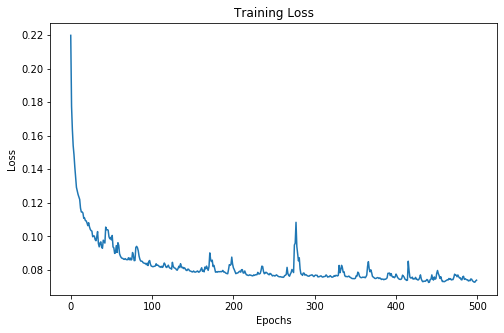

In [7]:
ae.plot_loss()

In [371]:
# get encodings
# reload if saved.
autoendings_path = '../_pickles/autoencoder_embeddings'

if not path.exists(autoendings_path):
    vals = ae.encoder.predict(data)
    with open(autoendings_path, 'wb') as pkl_file:
        pickle.dump(vals, pkl_file)
else:
    print('Reloading saved embeddings')
    with open(autoendings_path, 'rb') as pkl_file:
        vals = pickle.load(pkl_file)

Reloading saved embeddings


## Visualize the Embedding

Predict the encodings from the encoder then plot the 2D embedding.

Its kind of a weird looking star.

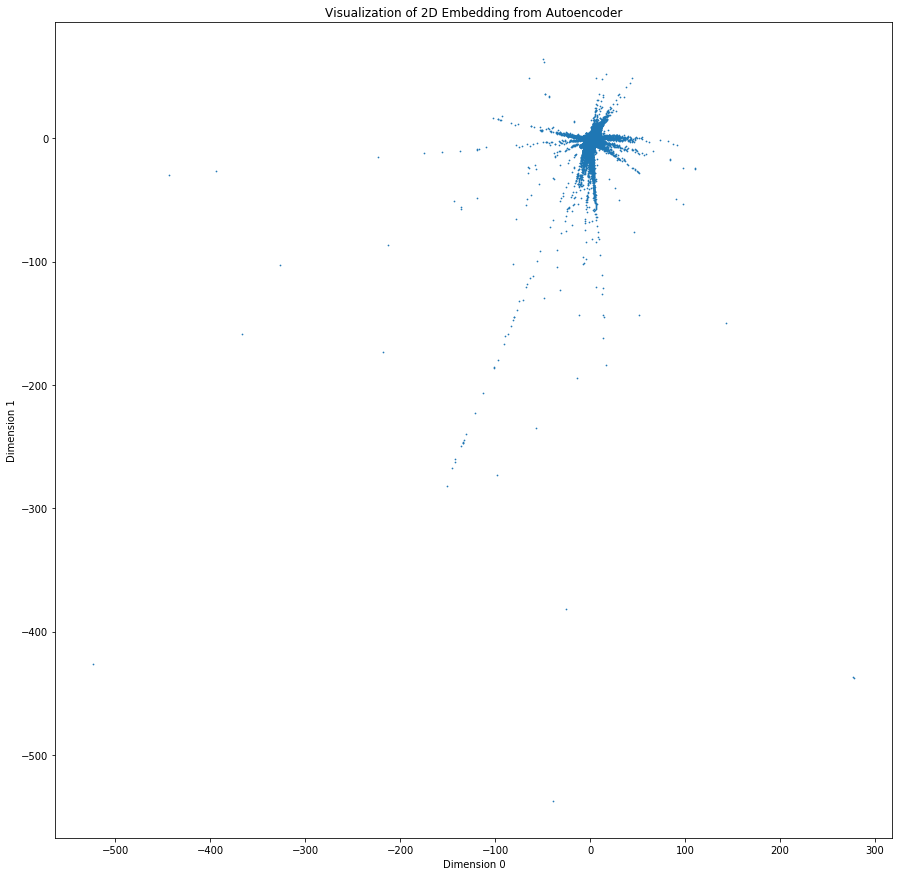

In [372]:
plt.figure(figsize = (15,15));
plt.scatter(vals[:, 0], vals[:, 1], s = 0.5);
plt.xlabel('Dimension 0');
plt.ylabel('Dimension 1');
plt.title('Visualization of 2D Embedding from Autoencoder');

# Clustering


## HDBSCAN Clustering

It looks like there is some fine variation in the center of the embeddings.
Density based clustering is able to capture some of the variation.

Note: HDBSCAN is run on 25% of the data due to computational difficulties with the whole dataset.

In [378]:
# select 80000 randomly and save indexes
autoendings_path = '../_pickles/autoencoder_embeddings_downsampled'

if not path.exists(autoendings_path):
    ind_plot = np.random.choice(np.arange(vals.shape[0]), replace = False, size = 80000)
    with open(autoendings_path, 'wb') as pkl_file:
        pickle.dump(ind_plot, pkl_file)
else:
    print('Reloading saved selection')
    with open(autoendings_path, 'rb') as pkl_file:
        ind_plot = pickle.load(pkl_file)

Reloading saved selection


In [364]:
km = hdbscan.HDBSCAN(min_cluster_size=40,
                     min_samples=5,
                     cluster_selection_epsilon = 0.025)
km.fit(vals[ind_plot,:])
labels = km.labels_

sampled = pd.DataFrame(data=vals[ind_plot,:],
                      columns=['one', 'two'])
sampled['labels'] = km.labels_

noise_count = sampled[sampled['labels'] == -1].count()[0]

In [366]:
print(f'There are {np.max(np.unique(labels))} clusters selected.')
print('Approximately {:0.2f}% of the data is classified as noise'.format(noise_count / ind_plot.size)).

There are 93 clusters selected.
Approximately 0.19% of the data is classified as noise


### Visualization

The following plot shows the results of HDBSCAN clustering on the embeddings with the extreme noise excluded.


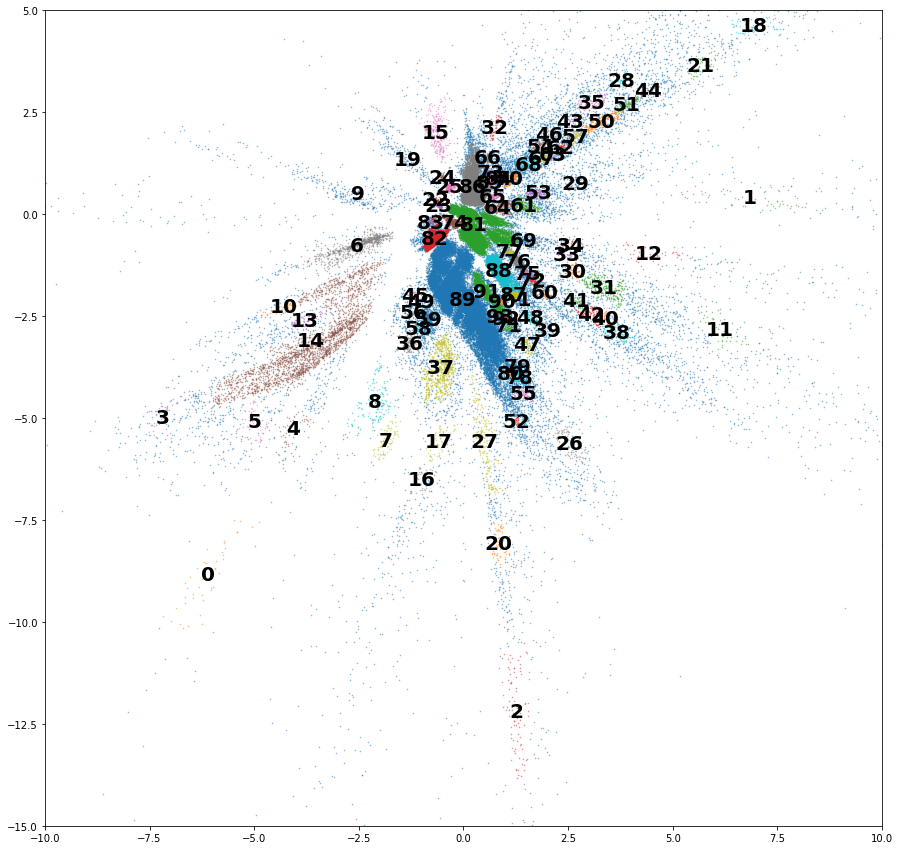

In [342]:
plt.figure(figsize = (15,15))
for label in np.unique(labels):
    plt.scatter(sampled.query('labels == ' + str(label)).one,
                sampled.query('labels == ' + str(label)).two,
                s = 0.3, alpha = 0.5);
    plt.xlim(-10,10)
    plt.ylim(-15,5);
    
    plt.annotate(label, 
                 sampled.loc[sampled['labels']==label,['one','two']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold') 

The following plot is zoomed into the previous plot to show the cluster labels better

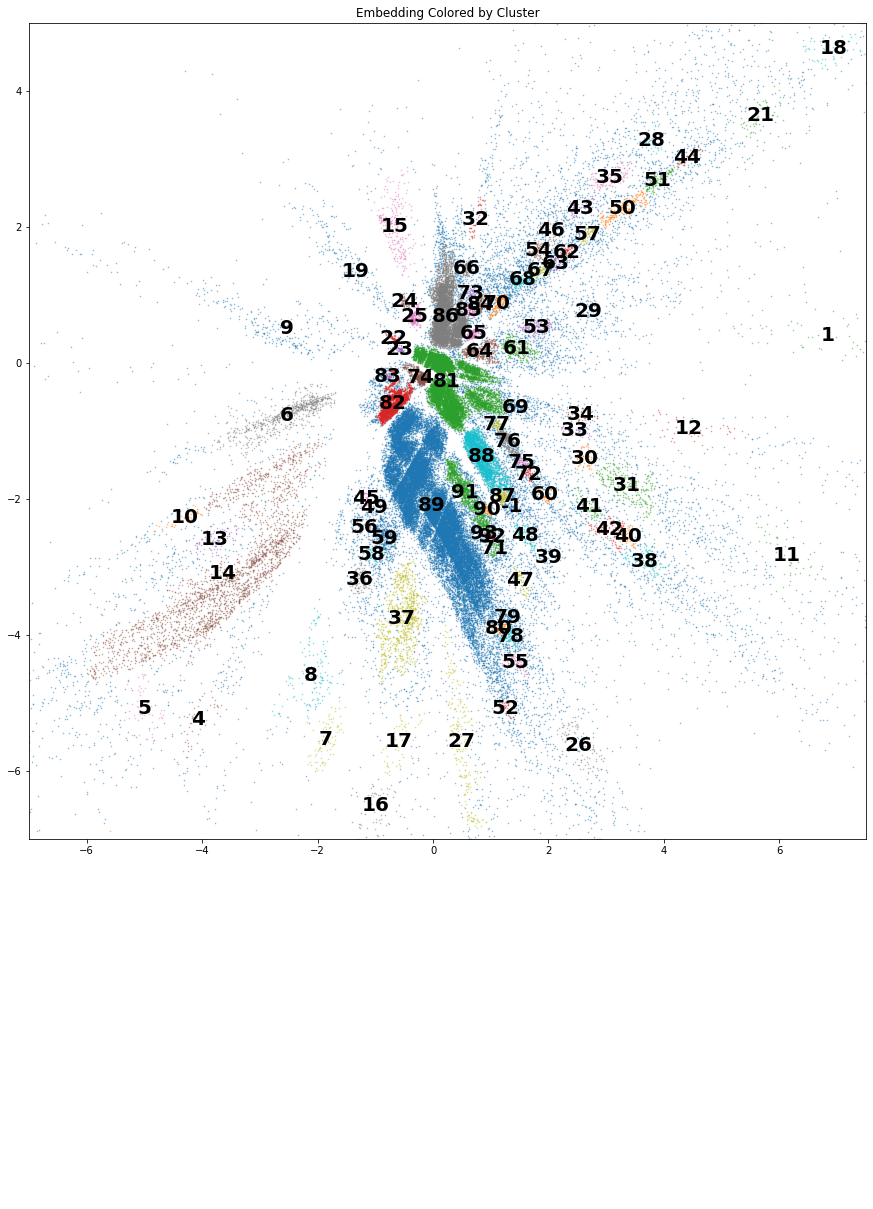

In [382]:
plt.figure(figsize = (15,15))
for label in np.unique(labels):
    plt.scatter(sampled.query('labels == ' + str(label)).one,
                sampled.query('labels == ' + str(label)).two,
                s = 0.3, alpha = 0.5);

    
    plt.annotate(label, 
                 sampled.loc[sampled['labels']==label,['one','two']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold') 
plt.title('Embedding Colored by Cluster');
plt.xlim(-7,7.5)
plt.ylim(-7,5);

The following plots show the relationship between the magnitude and the membership of the clusters.
Cluster 14 appears to be an outlier.
There also appear to be some outliers in the 500 membership range.

In [290]:
# drop the -1 if exists
cl = np.unique(labels)[np.unique(labels) != -1]
# pairwise distances
magnitude = np.empty_like(cl, dtype = 'float')
card = np.empty_like(cl)

for i, label in enumerate(cl):
    # get center
    center = sampled.loc[sampled['labels']==label,['one','two']].mean().values.reshape(1,2)
    # calculate distances from center
    diff = sampled.query('labels == ' + str(label))[['one', 'two']].values - center
    card[i] = diff.shape[0]
    magnitude[i] = np.sqrt((diff * diff).sum(1).sum())

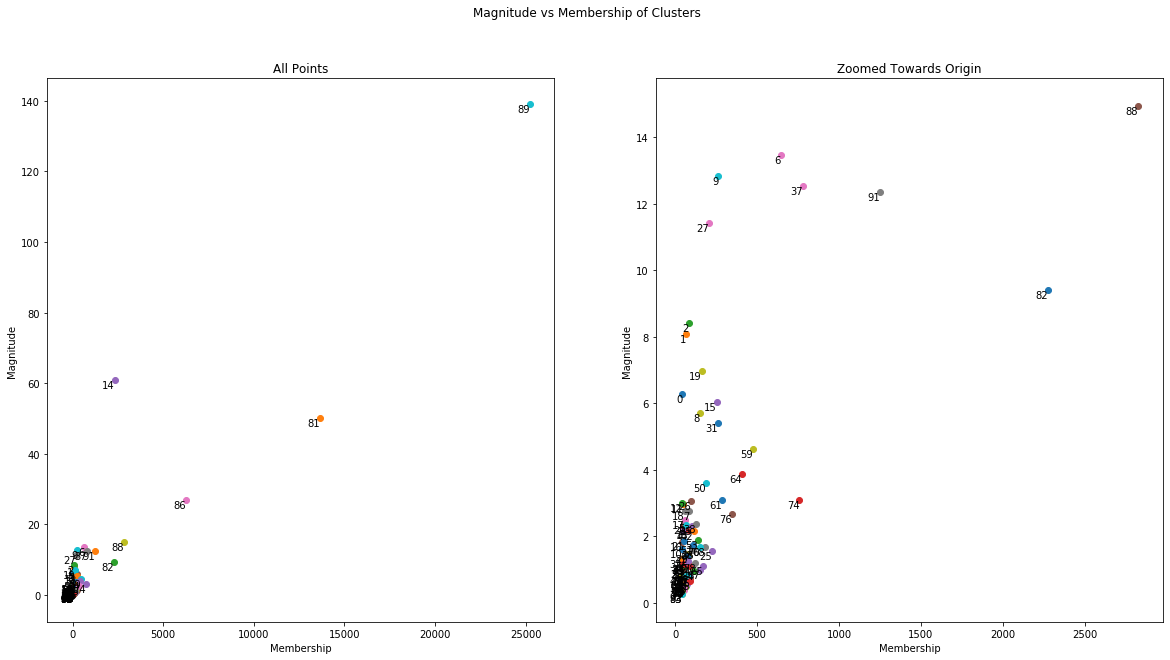

In [334]:
fig, ax = plt.subplots(1, 2, figsize = (20,10))
for c, m, label in zip(card, magnitude, cl):
    ax[0].scatter(c, m)
    ax[0].annotate(label, 
                 (c, m),
                 horizontalalignment='right',
                 verticalalignment='top',
                 size=10) 

    if c < 73000 and m < 15: 
        ax[1].scatter(c, m)
        ax[1].annotate(label, 
                     (c, m),
                     horizontalalignment='right',
                     verticalalignment='top',
                     size=10) 

ax[0].set_ylabel('Magnitude')
ax[0].set_xlabel('Membership');
ax[0].set_title('All Points')
ax[1].set_ylabel('Magnitude')
ax[1].set_xlabel('Membership');
ax[1].set_title('Zoomed Towards Origin')
fig.suptitle('Magnitude vs Membership of Clusters');

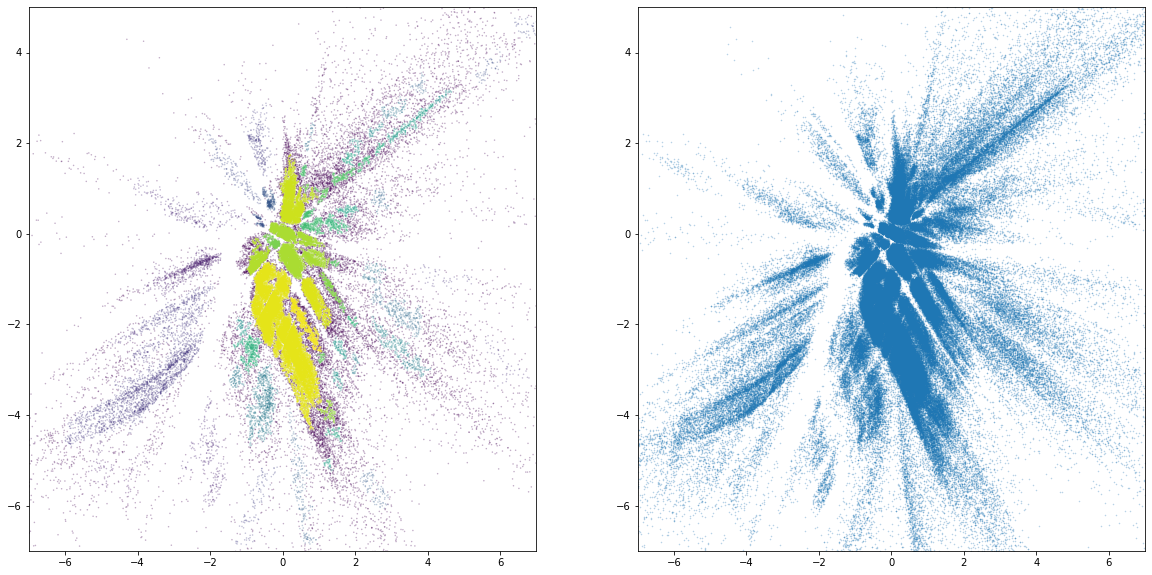

In [336]:
fig, ax = plt.subplots(1, 2, figsize = (20,10))
ax[0].scatter(vals[ind_plot, 0], vals[ind_plot, 1], s = 0.3, alpha = 0.3, c= labels);
ax[0].set_xlim(-7,7)
ax[0].set_ylim(-7,5)
ax[1].scatter(vals[:, 0], vals[:, 1], s = 0.3, alpha = 0.3);
ax[1].set_xlim(-7,7)
ax[1].set_ylim(-7,5);

### Scoring

The silhouette score is very low.

In [327]:
silhouette_score(sampled.query('labels != -1')[['one', 'two']],sampled.query('labels != -1')[['labels']])

/home/stuart/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.05769195

## Agglomerative Clustering

The 'core' clusters created by agglomerative clustering appear to be reasonable.
Also, it tends to pickup on noise.

Note: downsampling is required to run agglomerative clustering due to the size of the dataset.

In [386]:
# save sampling for reproducibility
autoendings_path = '../_pickles/autoencoder_embeddings_downsampled_agglom'

if not path.exists(autoendings_path):
    ind = np.random.choice(np.arange(vals.shape[0]), replace = False, size = 30000)
    with open(autoendings_path, 'wb') as pkl_file:
        pickle.dump(ind, pkl_file)
else:
    print('Reloading saved selection')
    with open(autoendings_path, 'rb') as pkl_file:
        ind = pickle.load(pkl_file)
# down sample the data
data_small = data.iloc[ind].copy()

Reloading saved selection


In [37]:
sil_scores = list()
sizes = [x for x in range(2, 200, 1)]

for n in sizes:
    sil_scores.append(
        silhouette_score(vals[ind , :], AgglomerativeClustering(n_clusters=n).fit_predict(vals[ind , :]))
    )

There is a high silhouette score below `n_clusters = 5`,
however, essentially only 1 cluster is actually chosen in these sets.
There appears to be an increase in mean silhouette score with increase in number of clusters,
but a smaller number of clusters may be useful for interpretation.
Additionally, tuning may improve performance.

(0, 25)

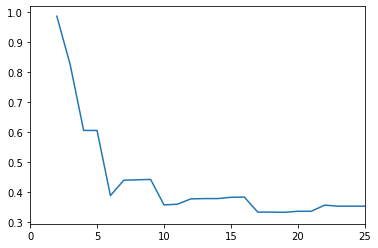

In [40]:
plt.plot(sizes, sil_scores)
plt.xlim((0,25))

### Sample Clustering

Mostly using the default here. 
Picked 8 for `n_clusters` because the silhouette score started to come up a bit.
With the number clusters set to 8, possibly 5 clusters appear to come up (maybe fewer). 
A visualization of the clusters is shwon below.

0    28052
1     1654
2      290
3        3
4        1
dtype: int64
0.6049827


(-50, 50)

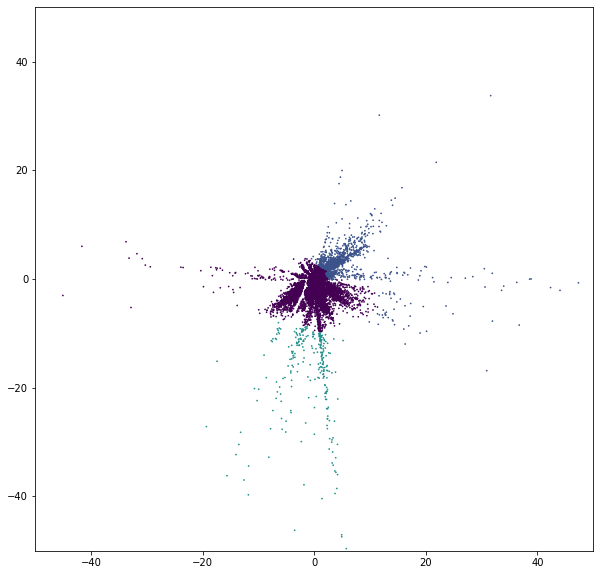

In [50]:
aglom = AgglomerativeClustering(n_clusters=5)
labels = aglom.fit_predict(vals[ind , :])
print(pd.Series(labels).value_counts())
print(silhouette_score(vals[ind , :], labels))
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

0    23127
5     4925
1     1654
2      290
3        3
4        1
dtype: int64
0.3872236


(-50, 50)

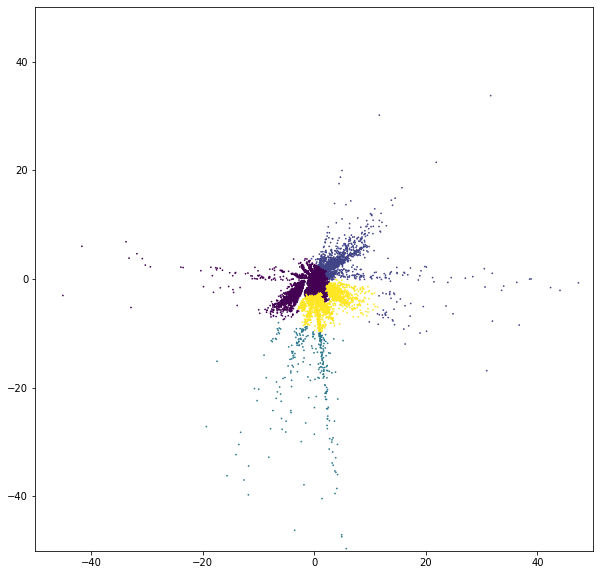

In [51]:
aglom = AgglomerativeClustering(n_clusters=6)
labels = aglom.fit_predict(vals[ind , :])
print(pd.Series(labels).value_counts())
print(silhouette_score(vals[ind , :], labels))
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

2    21825
5     4925
1     1654
6     1302
0      290
3        3
4        1
dtype: int64
0.43866476


(-50, 50)

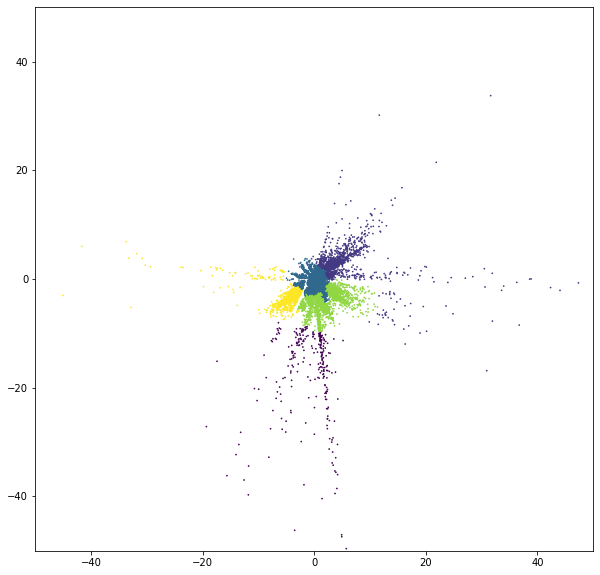

In [49]:
aglom = AgglomerativeClustering(n_clusters=7)
labels = aglom.fit_predict(vals[ind , :])
print(pd.Series(labels).value_counts())
print(silhouette_score(vals[ind , :], labels))
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

2    21825
5     4925
0     1654
6     1302
1      277
7       13
3        3
4        1
dtype: int64
0.43985787


(-50, 50)

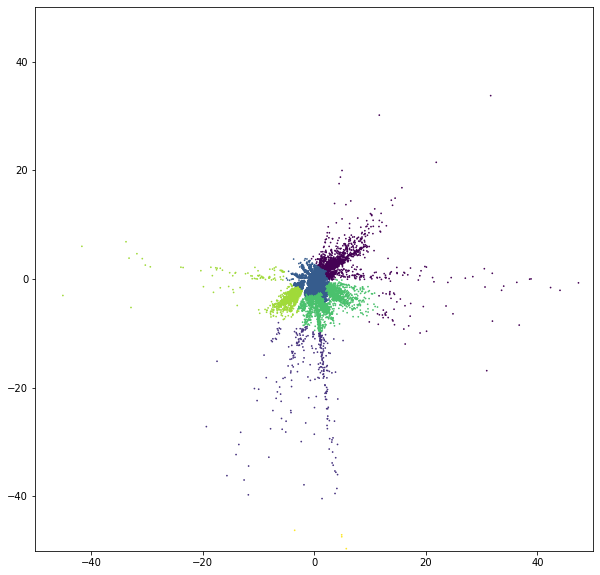

In [48]:
aglom = AgglomerativeClustering(n_clusters=8)
labels = aglom.fit_predict(vals[ind , :])
print(pd.Series(labels).value_counts())
print(silhouette_score(vals[ind , :], labels))
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

0    21825
5     4925
6     1561
2     1302
1      277
8       93
7       13
3        3
4        1
dtype: int64
0.44134063


(-50, 50)

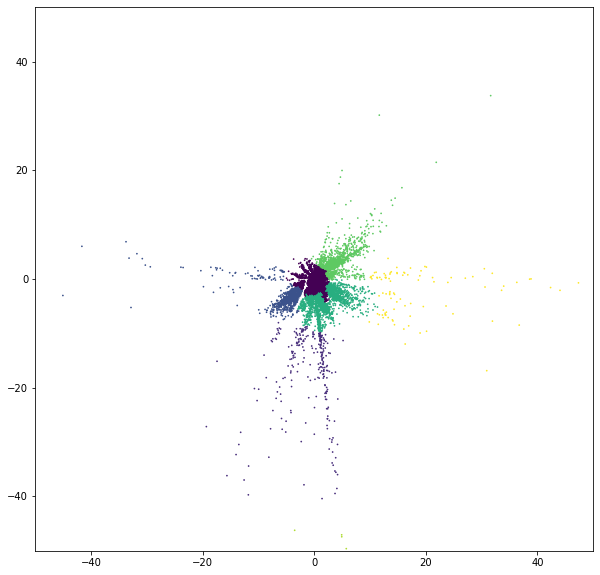

In [47]:
aglom = AgglomerativeClustering(n_clusters=9)
labels = aglom.fit_predict(vals[ind , :])
print(pd.Series(labels).value_counts())
print(silhouette_score(vals[ind , :], labels))
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

Note that setting `_clusters` to 2 or 3 basically just picks one primary cluster.
Clustering for `n = 2` shown below.

(-50, 50)

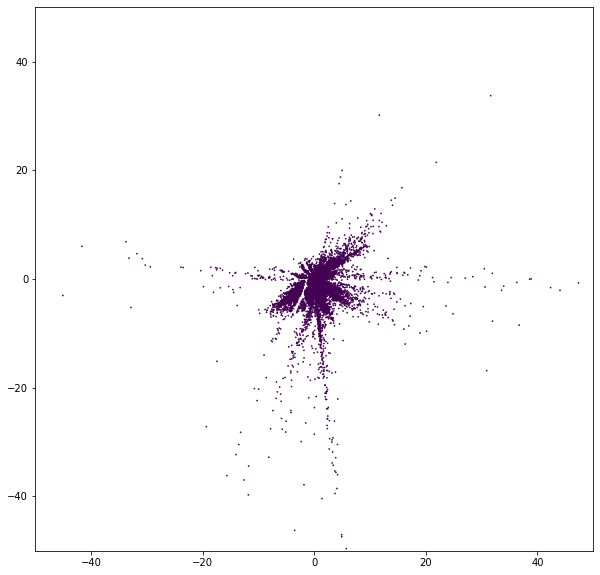

In [39]:
aglom = AgglomerativeClustering(n_clusters=2)
labels = aglom.fit_predict(vals[ind , :])
plt.figure(figsize=(10,10))
plt.scatter(vals[ind , 0],vals[ind , 1],c = labels, s = 0.5)
plt.xlim((-50,50))
plt.ylim((-50,50))

# Interpretation by Decision Trees

In [348]:
dtc = DecisionTreeClassifier(random_state=42,
                             max_leaf_nodes=5,
                            min_samples_leaf=500)

In [349]:
dtc.fit(data_small.iloc[:, :100], labels)
preds = dtc.predict(data_small.iloc[:, :100])

In [350]:
pd.Series(preds).value_counts()

1    18231
4    10413
6     1356
dtype: int64

In [340]:
labels

array([1, 1, 2, ..., 4, 1, 1])

In [368]:
pd.crosstab(preds, labels)

col_0,0,1,2,3,4
row_0,,,,,
1,17217,999,10,1,4
4,1988,7823,599,0,3
6,7,282,1066,0,1


In [351]:
# Creates dot file named tree.dot
export_graphviz(
            dtc,
            out_file =  "./myTreeName.dot",
            feature_names = list(data_small.iloc[:, :100].columns),
            class_names = dtc.classes_.astype(str),
            filled = True,
            rounded = True)

Generate png with 
```bash
$ dot -Tpng myTreeName.dot -o tree.png
```

In [242]:
data_small.iloc[:, :100]

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,EMPLOYED,BUREAU_CREDIT_ACTIVE_Active,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_CURRENCY_currency 1,BUREAU_CREDIT_CURRENCY_currency 2,BUREAU_CREDIT_CURRENCY_currency 3,BUREAU_CREDIT_TYPE_Another type of loan
277304,-0.370400,1.19000,0.31350,0.9795,0.03620,2.16200,-1.37000,0.69240,-0.1741,-0.1686,...,0,0,1,0.2500,0.7500,0.0,1.0000,0.0000,0.0,0.0
229414,0.426800,0.38800,0.64500,0.3700,0.56600,-0.62060,0.55200,-1.62500,-0.5910,-0.5894,...,0,0,1,0.0000,1.0000,0.0,1.0000,0.0000,0.0,0.0
118157,0.331800,-0.35910,-0.48900,-0.2269,0.25950,1.04200,0.21890,-1.50700,-0.5910,-0.5894,...,0,0,1,0.6250,0.3750,0.0,1.0000,0.0000,0.0,0.0
24393,-0.427200,-0.87350,-1.22900,-0.7876,1.56900,-0.84700,1.13300,1.00800,-0.5910,-0.5894,...,0,0,0,0.0000,1.0000,0.0,1.0000,0.0000,0.0,0.0
158267,-0.028670,0.95460,1.92600,0.9795,-0.45800,1.78900,-1.21800,0.93000,0.6597,0.6730,...,0,0,1,0.7500,0.2500,0.0,1.0000,0.0000,0.0,0.0
304625,-0.427200,-0.98540,-1.17200,-0.9090,-0.75440,0.12960,0.47020,0.98440,-0.5910,-0.5894,...,0,0,1,0.6665,0.3333,0.0,1.0000,0.0000,0.0,0.0
20129,0.047240,0.24460,0.70260,0.4312,0.73630,-0.15430,-1.37600,-0.69200,-0.5910,-0.5894,...,0,0,1,0.2500,0.7500,0.0,1.0000,0.0000,0.0,0.0
47167,0.199100,-0.37040,-0.31790,-0.2391,0.16300,2.64000,-0.64940,-1.79400,-0.1741,-0.1686,...,0,0,1,0.7144,0.2856,0.0,1.0000,0.0000,0.0,0.0
52075,0.047240,1.71300,0.73800,1.5890,-0.99070,0.83740,-0.37670,-0.49500,1.4940,1.5140,...,0,0,1,0.1428,0.8570,0.0,1.0000,0.0000,0.0,0.0
182778,-0.237400,-0.87400,-0.29660,-0.8486,-1.40000,-0.75340,-0.10364,-1.57200,-0.5910,-0.5894,...,0,0,1,1.0000,0.0000,0.0,1.0000,0.0000,0.0,0.0
